In [ ]:
"""
    Python notebook for sentiment visualization as a graph problem
    And other experimentations: centrality measures, correlations, one way tests.
"""

In [1]:
import json
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
country = "GB"
season = "2019"
weekgame = "38"
file_title = country + '/' + season + '/' + weekgame + "_analysis.csv"
df = pd.read_csv(file_title)
print(df.shape)
df.head(5)

(1915, 21)


,Unnamed: 0,season,weekgame,home_team,away_team,favorite_count,lang,retweet_count,retweeted,text,...,verified,user,pre_label,no_mentions,support,with_emojis,sentiment,score,m_support,m_sentiment
0,0,2019,38,LEI,MUN,0,en,0,False,@DeporFinanzas @bardofstreets @LFC @FCBarcelon...,...,False,hassanthegr8,1,even an underperforming barca is at number 2,-1,@DeporFinanzas @bardofstreets @LFC @FCBarcelon...,-1,0,-1,-1
1,1,2019,38,LEI,MUN,0,en,0,False,@tpitch51 @premierleague @HolaItsAbdullah @LCF...,...,False,hassanthegr8,1,its all about today now,0,@tpitch51 @premierleague @HolaItsAbdullah @LCF...,1,0,0,1
2,2,2019,38,LEI,MUN,0,en,0,False,Excitement has now turned to nerves! Come on @...,...,False,DeanJohnsonMUFC,1,Excitement has now turned to nerves Come on on...,-1,Excitement has now turned to nerves! Come on @...,1,0,-1,1
3,3,2019,38,LEI,MUN,1,en,0,False,@ManUtd Don't be shit :-),...,False,SammonDStallion,1,Don t be shit,-1,@ManUtd Don't be shit good,-1,0,-1,-1
4,4,2019,38,LEI,MUN,1,en,0,False,Gonna watch the match between @ManUtd and @LC...,...,False,Riyel_19,1,Gonna watch the match between and Which team i...,0,Gonna watch the match between @ManUtd and @LCF...,0,0,0,0


In [3]:
# Load the dictionary of the current teams
file_title = country + '/' + country + '_twitter.json'
dct = dict()
with open(file_title, 'r') as j:
     dct = json.loads(j.read())

In [4]:
# Create a map frequency by team
# For example this will increase the importance with less tweeted teams
def return_index(index):
    if index == -1:
        return 2
    if index == 1:
        return 0
    if index == 0:
        return 1

# For sentiment [positive, neutral, negative]
# For support [home_team, both, away_team]
def group_distribution(grouped, dct):
    dct_teams = dict()
    for ite, row in grouped.iterrows():
        home_team = dct[ite[0]]['mention'][1:].lower()
        away_team = dct[ite[1]]['mention'][1:].lower()
        if home_team not in dct_teams:
            dct_teams[home_team] = 0
        if away_team not in dct_teams:
            dct_teams[away_team] = 0
        if ite[2] == 1:
            dct_teams[home_team]+=row["season"]
        if ite[2] == -1:
            dct_teams[away_team]+=row["season"]
        if  ite[2] == 0:
            dct_teams[home_team]+=row["season"]//2
            dct_teams[away_team]+=row["season"]//2
    return dct_teams

In [5]:
# Function that returns the user of the home/away team given a support
def support_team(row):
    if row['m_support'] == 1:
        team = row['home_team']
    elif row['m_support'] == -1:
        team = row['away_team']
    else:
        home_team = row['home_team']
        away_team = row['away_team']
        return dct[away_team]['mention'][1:].lower(), dct[home_team]['mention'][1:].lower()
    account = dct[team]['mention'][1:].lower()
    return account, None

In [6]:
# Function that weights an edge given retweet count and favorite count
def weight_tweet(row, team, dct_freq):
    freq_team = dct_freq[team]
    return 2 + ((row['favorite_count'] + row['retweet_count']) / freq_team)
# Returns a color given a sentiment
def color_sentiment(polarity):
    if polarity == 0:
        return 'steelblue'
    if polarity == 1:
        return 'navy'
    if polarity == -1:
        return 'lightseagreen'

In [14]:
def create_graph(df, modified, dct, match, axs):
    axs.set_title(str(match[0]) + " vs. " + str(match[1]))
    dct_cc = dict()
    # Creates the graph
    G=nx.MultiGraph()
    nodes = df['user'].unique()
    # Add nodes
    G.add_nodes_from(nodes)
    # Frequency of teams mentions
    dct_freq = group_distribution(modified, dct)
    
    # Add weighted undirected arcs
    home_team = dct[match[0]]['mention'][1:].lower()
    away_team = dct[match[1]]['mention'][1:].lower()
    for index, row in df.iterrows():
        team, both = support_team(row)
        oponent = None
        # The inverted
        if team != away_team:
            oponent = away_team
        else:
            oponent = home_team
        if both:
            if row['m_sentiment'] == -1:
                G.add_edge(row['user'], home_team, sentiment=1, color=color_sentiment(1) , weight=weight_tweet(row, away_team, dct_freq))
                G.add_edge(row['user'], away_team, sentiment=1, color=color_sentiment(1) , weight=weight_tweet(row, home_team, dct_freq))
            else:
                G.add_edge(row['user'], both, sentiment=row['m_sentiment'], color=color_sentiment(row['m_sentiment']), weight=weight_tweet(row, both, dct_freq))
        elif row['m_sentiment'] == -1:
            G.add_edge(row['user'], oponent, sentiment=1, color=color_sentiment(1) , weight=weight_tweet(row, team, dct_freq))
        else:
            G.add_edge(row['user'], team, sentiment=row['m_sentiment'], color=color_sentiment(row['m_sentiment']) , weight=weight_tweet(row, team, dct_freq))
    #fig, axs = plt.subplots(1,1, figsize=(10,10))
    #fig.suptitle(str(match[0]) + " vs. " + str(match[1]))

    edges = G.edges()

    colors = []
    weight = []

    for (u,v,attrib_dict) in list(G.edges.data()):
        colors.append(attrib_dict['color'])
        weight.append(attrib_dict['weight'])
    
    mentions = [v["mention"][1:].lower() for v in dct.values()]
    
    color_map = []
    for node in G:
        if node in mentions:
            color_map.append('blue')
        else: 
            color_map.append('green')
    
    pos = nx.spring_layout(G)
    labels = {
                home_team: home_team,
                away_team: away_team
    }
    nx.draw_spring(G, node_size=10, node_color=color_map, edge_color=colors, width=weight, labels=labels, ax=axs)
    #plt.show()
    cc = nx.closeness_centrality(G)
    cfc = nx.current_flow_closeness_centrality(G, weight='weight')
    hc = nx.harmonic_centrality(G)
    sizeg = len(G.nodes().keys())-1
    print("Home team %s, cc %s, cfc %s, hc %s" %(home_team, cc[home_team], cfc[home_team], hc[home_team]/sizeg))
    print("Away team %s, cc %s, cfc %s, hc %s" %(away_team, cc[away_team], cfc[away_team], hc[away_team]/sizeg))
    dct_cc["o_cc_home"] = cc[home_team]
    dct_cc["o_cc_away"] = cc[away_team]
    dct_cc["o_cfc_home"] = cfc[home_team]
    dct_cc["o_cfc_away"] = cfc[away_team]
    dct_cc["o_hc_home"] = hc[home_team]/sizeg
    dct_cc["o_hc_away"] = hc[away_team]/sizeg
    # positive - navy
    # negative - lightseagreen DOESNT EXIST ANYMORE
    # neutral - steelblue REMOVED
    P = nx.MultiGraph()
    Neu = nx.MultiGraph()
    for (u,v,attrib_dict) in list(G.edges.data()):
        if attrib_dict['color'] == 'navy':
            if u not in P:
                P.add_node(u)
            if v not in P:
                P.add_node(v)
            P.add_edge(u, v, color=attrib_dict['color'], weight=attrib_dict['weight'])
                   
    cc = nx.closeness_centrality(P)
    cfc = nx.current_flow_closeness_centrality(P, weight='weight')
    hc = nx.harmonic_centrality(P)
    sizep = len(P.nodes().keys())-1
    # Normalize harmonic centrality / N - 1 vertices
    print("Positive polarity")
    print("Home team %s, cc %s, cfc %s, hc %s" %(home_team, cc[home_team], cfc[home_team], hc[home_team]/sizep))
    print("Away team %s, cc %s, cfc %s, hc %s" %(away_team, cc[away_team], cfc[away_team], hc[away_team]/sizep))
    dct_cc["p_cc_home"] = cc[home_team]
    dct_cc["p_cc_away"] = cc[away_team]
    dct_cc["p_cfc_home"] = cfc[home_team]
    dct_cc["p_cfc_away"] = cfc[away_team]
    dct_cc["p_hc_home"] = hc[home_team]/sizep
    dct_cc["p_hc_away"] = hc[away_team]/sizep
    return dct_cc

0 0
Home team arsenal, cc 0.5574572127139364, cfc 0.008867317394886554, hc 0.7346491228070213
Away team watfordfc, cc 0.48, cfc 0.008695354333347635, hc 0.6381578947368428
Positive polarity
Home team arsenal, cc 0.5175438596491229, cfc 0.01110443287096246, hc 0.6883239171374743
Away team watfordfc, cc 0.5145348837209303, cfc 0.011080876160288244, hc 0.6845574387947247
0 1
Home team burnleyofficial, cc 0.6853146853146853, cfc 0.025403387613599497, hc 0.8452380952380941
Away team officialbhafc, cc 0.5025641025641026, cfc 0.02504408978947919, hc 0.6683673469387764
Positive polarity
Home team burnleyofficial, cc 0.6451612903225806, cfc 0.04623933008564996, hc 0.8138888888888896
Away team officialbhafc, cc 0.631578947368421, cfc 0.04613911807003156, hc 0.8027777777777785
0 2
Home team chelseafc, cc 0.5910290237467019, cfc 0.009456819998998073, hc 0.7686011904761937
Away team wolves, cc 0.469601677148847, cfc 0.009380247542523458, hc 0.6227678571428567
Positive polarity
Home team chelseafc, 

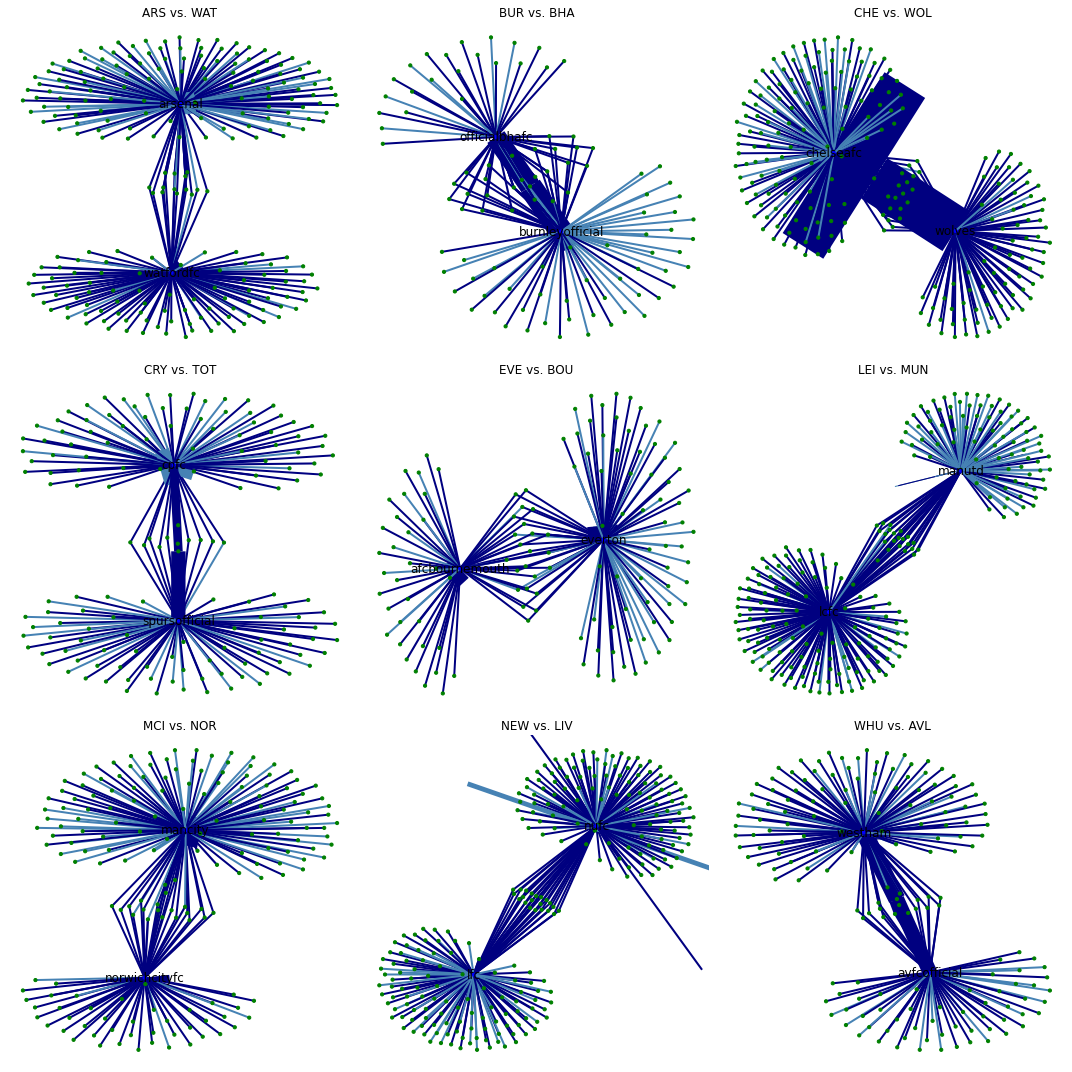

In [15]:
matches = df.groupby(['home_team','away_team'])
modified = df.groupby(['home_team','away_team','m_support']).count()
cc = pd.DataFrame()
# Labels balance
r = 3
c = 3
fig, axs = plt.subplots(r, c, figsize=(15,15))
# Create index mat
mat = [[i,j] for i in range(0, r) for j in range(0, c)]
i = 0
for key, val in matches:
    if key[0] != 'SU':
        print(mat[i][0], mat[i][1])
        dct_cc = create_graph(val.apply(lambda x: x), modified, dct, key, axs[mat[i][0], mat[i][1]])
        cc = cc.append(dct_cc, ignore_index=True)
        i = i + 1
fig.tight_layout()
plt.show()

In [9]:
target = [1, -1, 1, 0, -1, -1, 1, -1, 0]
cc["target"] = target

In [310]:
cc.head()

,n_cc_away,n_cc_home,n_cfc_away,n_cfc_home,n_hc_away,n_hc_home,neu_cc_away,neu_cc_home,neu_cfc_away,neu_cfc_home,...,o_cfc_home,o_hc_away,o_hc_home,p_cc_away,p_cc_home,p_cfc_away,p_cfc_home,p_hc_away,p_hc_home,target
0,0.391473,0.765152,0.017088,0.020163,0.480198,0.896040,0.452381,0.695122,0.038577,0.039414,...,0.009646,0.497807,0.901316,0.377880,0.828283,0.020296,0.025356,0.449187,0.928862,1
1,0.833333,0.760870,0.100996,0.100158,0.928571,0.890476,0.931818,0.759259,0.089196,0.088122,...,0.032966,0.933673,0.831633,0.731707,0.508475,0.088923,0.085510,0.872222,0.672222,-1
2,0.387097,0.884211,0.025267,0.026072,0.470238,0.954365,0.463636,0.822581,0.047450,0.049140,...,0.010322,0.533482,0.929315,0.419492,0.773438,0.020471,0.021986,0.537037,0.900673,1
3,0.661765,0.459184,0.048054,0.045473,0.825926,0.603704,0.634921,0.493827,0.057121,0.055718,...,0.014622,0.817673,0.607383,0.626087,0.452830,0.027301,0.025316,0.798611,0.594907,0
4,0.618421,0.602564,0.053026,0.052811,0.790780,0.776596,0.585714,0.683333,0.062003,0.062694,...,0.021554,0.789973,0.806233,0.623377,0.607595,0.052544,0.052473,0.795139,0.781250,-1


In [1]:
def study(data):
    df = pd.DataFrame()
    #df["hc_p_home"] = data["o_hc_home"]-data["p_hc_home"]
    #df["hc_n_home"] = data["o_hc_home"]-data["n_hc_home"]
    #df["hc_neu_home"] = data["o_hc_home"]-data["neu_hc_home"]
    #df["hc_p_away"] = data["o_hc_away"]-data["p_hc_away"]
    #df["hc_n_away"] = data["o_hc_away"]-data["n_hc_away"]
    #df["hc_neu_away"] = data["o_hc_away"]-data["neu_hc_away"]
    df["diff_o_hc"] = abs(data["o_hc_home"]-data["o_hc_away"])
    df["diff_p_hc"] = abs(data["p_hc_home"]-data["p_hc_away"])
    df["diff_n_hc"] = abs(data["n_hc_home"]-data["n_hc_away"])
    df["diff_neu_hc"] = abs(data["neu_hc_home"]-data["neu_hc_away"])
    df["diff_o_cc"] = abs(data["o_cc_home"]-data["o_cc_away"])
    df["diff_p_cc"] = abs(data["p_cc_home"]-data["p_cc_away"])
    df["diff_n_cc"] = abs(data["n_cc_home"]-data["n_cc_away"])
    df["diff_neu_cc"] = abs(data["neu_cc_home"]-data["neu_cc_away"])
    df["o_cfc_home"] = data["o_cfc_home"]
    df["o_cfc_away"] = data["o_cfc_away"]
    df["p_cfc_home"] = data["p_cfc_home"]
    df["p_cfc_away"] = data["p_cfc_away"]
    df["n_cfc_home"] = data["n_cfc_home"]
    df["n_cfc_away"] = data["n_cfc_away"]
    df["neu_cfc_home"] = data["neu_cfc_home"]
    df["neu_cfc_away"] = data["neu_cfc_away"]
    #df["diff_p_cfc"] = abs(data["p_cfc_home"]-data["p_cfc_away"])
    #df["diff_n_cfc"] = abs(data["n_cfc_home"]-data["n_cfc_away"])
    #df["diff_neu_cfc"] = abs(data["neu_cfc_home"]-data["neu_cfc_away"])
    df["target"] = data["target"]
    return df

In [369]:
# This returns the correlation matrix, as well the features correlated over a given trheshold
def get_correlation(data, target, column_names, corr_method, target_name, thresh=0.5):
    df = pd.DataFrame(data, columns=column_names)
    df[target_name] = target
    X = df.drop(target_name,1)   #Feature Matrix
    y = df[target_name] 
    
    #Using Spearman Correlation
    corr = df.corr(method=corr_method)
    
    #Correlation with output variable biggest magnitude
    cor_target = abs(corr[target_name])
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>thresh]
    relevant_features = relevant_features.sort_values(ascending=False)
    
    return corr, relevant_features

# Use in the future
def heatmap_data(data, target, column_names, corr_method, target_name):
    #Using Spearman Correlation
    corr, _ = get_correlation(data, target, column_names, corr_method, target_name)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='mako', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Features vs Target")
    plt.show()

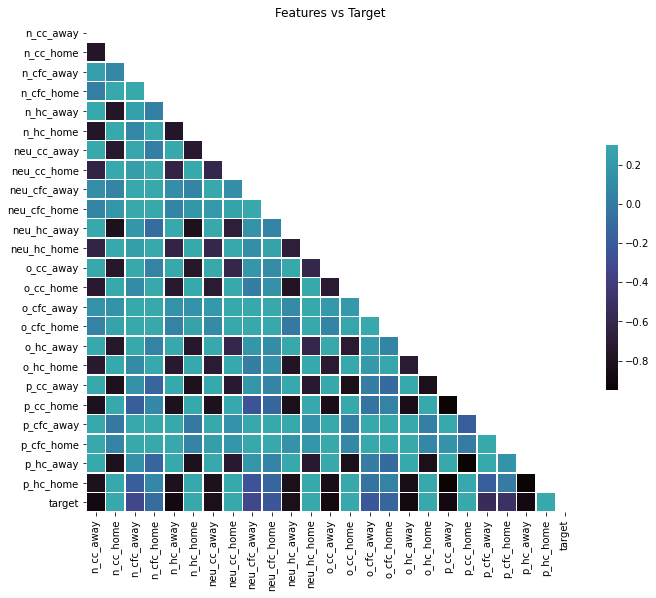

In [370]:
heatmap_data(cc, target, cc.columns, 'spearman', 'target')

In [371]:
_, relevant_features = get_correlation(cc, target, cc.columns, 'spearman', 'target', thresh=0.5)
print(relevant_features)

target         1.000000
p_cc_away      0.881962
n_hc_away      0.881962
o_hc_away      0.881962
o_cc_away      0.881962
p_hc_away      0.881962
n_cc_away      0.881962
neu_hc_away    0.828510
neu_cc_away    0.828510
p_cc_home      0.775058
p_hc_home      0.775058
o_hc_home      0.721605
o_cc_home      0.721605
n_hc_home      0.721605
n_cc_home      0.721605
neu_hc_home    0.623610
neu_cc_home    0.623610
p_cfc_away     0.543431
Name: target, dtype: float64


In [2]:
new_cc = study(cc)
heatmap_data(new_cc, target, new_cc.columns, 'spearman', 'target')

NameError: name 'cc' is not defined

In [377]:
_, relevant_features = get_correlation(new_cc, target, new_cc.columns, 'spearman', 'target', thresh=0.3)
print(relevant_features)

target          1.000000
diff_p_hc       0.472162
diff_p_cc       0.418709
diff_p_cfc      0.391983
diff_o_cfc      0.391983
diff_n_cfc      0.383074
diff_neu_cfc    0.329622
diff_n_hc       0.320713
Name: target, dtype: float64


In [378]:
from scipy.stats import f_oneway

def anova_test(data, target):
    cols = []
    for c in data.columns:
        F, p = f_oneway(data[c], target)
        if p <= 0.05:
            print("column = %s, p-val = %s" %(c, p))
            cols.append(c)
    return cols

In [379]:
cols = anova_test(cc, target)

column = n_cc_away, p-val = 0.033397759630908776
column = n_cc_home, p-val = 0.030395403415746966
column = n_hc_away, p-val = 0.01597690882750392
column = n_hc_home, p-val = 0.014211868859477391
column = neu_cc_away, p-val = 0.0284804913557279
column = neu_cc_home, p-val = 0.03009135235539661
column = neu_hc_away, p-val = 0.012056030867570568
column = neu_hc_home, p-val = 0.012504904024729173
column = o_cc_away, p-val = 0.03445703071036828
column = o_cc_home, p-val = 0.03252214163693265
column = o_hc_away, p-val = 0.01529294841552079
column = o_hc_home, p-val = 0.013757405514599027
column = p_cc_away, p-val = 0.042676056235563586
column = p_cc_home, p-val = 0.0366624478609397
column = p_hc_away, p-val = 0.01892396283143763
column = p_hc_home, p-val = 0.01512199336352896


In [380]:
anova_test(new_cc, target)

[]

In [381]:
anova_df = cc[cols]

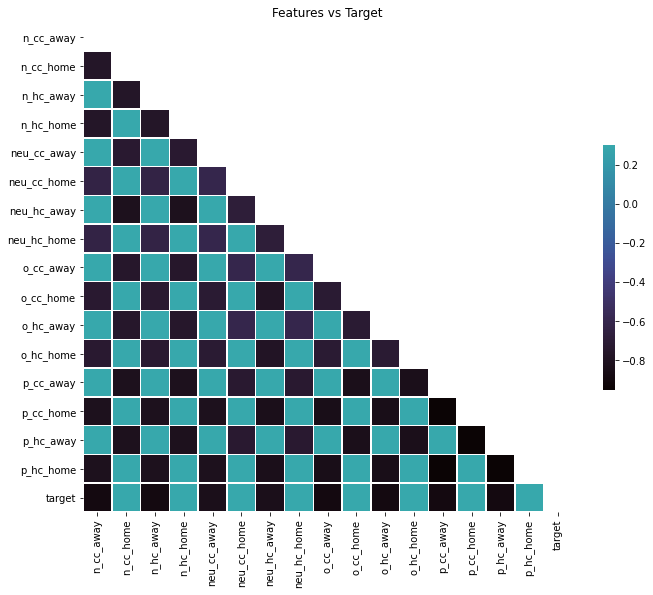

In [382]:
heatmap_data(anova_df, target, anova_df.columns, 'spearman', 'target')

In [354]:
_, relevant_features = get_correlation(anova_df, target, anova_df.columns, 'spearman', 'target', thresh=0.5)
print(relevant_features)

target         1.000000
p_cc_away      0.881962
n_hc_away      0.881962
o_hc_away      0.881962
o_cc_away      0.881962
p_hc_away      0.881962
n_cc_away      0.881962
neu_hc_away    0.828510
neu_cc_away    0.828510
p_cc_home      0.775058
p_hc_home      0.775058
o_hc_home      0.721605
o_cc_home      0.721605
n_hc_home      0.721605
n_cc_home      0.721605
neu_hc_home    0.623610
neu_cc_home    0.623610
Name: target, dtype: float64
